In [0]:
# A user prompt to enter a value for myfile1, 
# the value should be name of the clinicaltrial file to be worked for the specific instance excluding the file extension. 
# E.g. If you are working with the 2023 file, you should enter clinicaltrial_2023 when prompted by the system and click Enter.

myfile1 = input("Enter the file name of the zipped clinical trial file you will be working with:")
myfile2 = "pharma"

Enter the file name of the zipped clinical trial file you will be working with: clinicaltrial_2023

In [0]:
import os
os.environ['myfile1'] = myfile1
os.environ['myfile2'] = myfile2

In [0]:
## Clear the content that needs to be created again from the DBFS

dbutils.fs.rm("/FileStore/tables/" + myfile1 + ".csv")
dbutils.fs.rm("/FileStore/tables/" + myfile2 + ".csv")

Out[3]: True

In [0]:
# Copy the file we want to unzip to the tmp folder in the local file system

dbutils.fs.cp("/FileStore/tables/" + myfile1 + ".zip", "file:/tmp/")
dbutils.fs.cp("/FileStore/tables/" + myfile2 + ".zip", "file:/tmp/")

Out[4]: True

In [0]:
%sh
# Unzipping the files in the local file system

unzip /tmp/$myfile1.zip -d /tmp
unzip /tmp/$myfile2.zip -d /tmp

Archive:  /tmp/clinicaltrial_2023.zip
  inflating: /tmp/clinicaltrial_2023.csv  
Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
dbutils.fs.mv("file:/tmp/" + myfile1 + ".csv", "/FileStore/tables/", True)
dbutils.fs.mv("file:/tmp/" + myfile2 + ".csv", "/FileStore/tables/", True)

Out[6]: True

In [0]:
# creating an RDD from its corresponding csv file

clinicaltrial_rdd = sc.textFile("/FileStore/tables/" + myfile1 + ".csv")

pharmaRDD = sc.textFile("/FileStore/tables/" + myfile2 + ".csv")

In [0]:
clinicaltrial_rdd.take(2)

Out[8]: ['"Id\tStudy Title\tAcronym\tStatus\tConditions\tInterventions\tSponsor\tCollaborators\tEnrollment\tFunder Type\tType\tStudy Design\tStart\tCompletion",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 '"NCT03630471\tEffectiveness of a Problem-solving Intervention for Common Adolescent Mental Health Problems in India\tPRIDE\tCOMPLETED\tMental Health Issue (E.G.", Depression, Psychosis, Personality Disorder," Substance Abuse)\tBEHAVIORAL: PRIDE \'Step 1\' problem-solving intervention|BEHAVIORAL: Enhanced usual care\tSangath\tHarvard Medical School (HMS and HSDM)|London School of Hygiene and Tropical Medicine\t250.0\tOTHER\tINTERVENTIONAL\tAllocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: DOUBLE (INVESTIGATOR"," OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT\t2018-08-20\t2019-02-28",,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [0]:
pharmaRDD.take(2)

Out[9]: ['"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"',
 '"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctors to implant the co

In [0]:
# Each row of data includes trailing commas which are not required for our purpose. We apply the rstrip() fucntion to remove any trailing commas at the end of each row.
#Each row of data is bounded by a double quote which could be removed by using the strip() function. The strip() function is applied to remove the quotes at the beginning and at the end of ach row
if (myfile1 == 'clinicaltrial_2023'):               
    clinicaltrial_rdd = clinicaltrial_rdd.map(lambda line: (line.rstrip(','))).\
        map(lambda line: line.strip('"')).\
            map(lambda line: line.split('\t')).\
                filter(lambda values: len(values) == 14)
else:
    clinicaltrial_rdd = clinicaltrial_rdd.map(lambda line: line.split("|"))

In [0]:
# An assumption will be made here that the parent company contains all possible pharmaceutical companies.
parentCompanyRDD = pharmaRDD.map(lambda x: x.split(',')[1]).\
    map(lambda x: x.strip('"')).\
        filter(lambda s: s != 'Parent_Company')

In [0]:
# Question 1 - The distinct number of studies in the dataset.
distint_num_studies_RDD = clinicaltrial_rdd.map(lambda col: col[0]).\
    filter(lambda s: s != 'Id' and s != '').\
        distinct().\
            count()
            
print(f"The Distinct Number of studies in the dataset is: {distint_num_studies_RDD}")

The Distinct Number of studies in the dataset is: 483420


In [0]:
# Question 2 - You should list all the types (as contained in the Type column) of studies in the dataset along with the frequencies of each type.
 
clinicaltrial_rdd.map(lambda col: col[10] if myfile1 == "clinicaltrial_2023" else col[5]).\
    filter(lambda s: s != 'Type' and s != '' )\
        .map(lambda s: (s, 1)).\
            reduceByKey(lambda a,b: a + b).\
                map(lambda x: (x[1], x[0])).\
                    sortByKey(ascending=False).\
                        map(lambda x: (x[1], x[0])).\
                            collect()

Out[13]: [('INTERVENTIONAL', 371382),
 ('OBSERVATIONAL', 110221),
 ('EXPANDED_ACCESS', 928)]

In [0]:
# Question 3 - The top 5 conditions (from Conditions) with their frequencies
          
top5_conditions_RDD = clinicaltrial_rdd.\
    map(lambda col: col[4] if myfile1 == "clinicaltrial_2023" else col[7]).\
    flatMap(lambda row: row.split("|") if myfile1 == "clinicaltrial_2023" else row.split(",")).\
        filter(lambda s: s != 'Conditions' and s != '').\
            map(lambda s: (s, 1)).\
                reduceByKey(lambda a,b: a + b).\
                    top(5, key = lambda line: line[1])

print('The top 5 conditions with their frequencies are:\n')
for i in range(len(top5_conditions_RDD)):
    print (f"{top5_conditions_RDD[i][0]}:   {top5_conditions_RDD[i][1]}")

The top 5 conditions with their frequencies are:

Healthy:   9731
Breast Cancer:   7502
Obesity:   6549
Stroke:   4071
Hypertension:   4020


In [0]:
# Question 4 - Find the 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored.

top10_coommon_sponsor_RDD = clinicaltrial_rdd.map(lambda line: line[6] if myfile1 == "clinicaltrial_2023" else line[1]).\
    filter(lambda s: s != 'Sponsor' and s != '').\
            subtract(parentCompanyRDD).\
                map(lambda s: (s, 1)).\
                    reduceByKey(lambda a,b: a + b).\
                        top(10, key = lambda line: line[1])


print('The 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored:\n')
for i in range(len(top10_coommon_sponsor_RDD)):
    print (f"{top10_coommon_sponsor_RDD[i][0]}:   {top10_coommon_sponsor_RDD[i][1]}")

The 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored:

National Cancer Institute (NCI):   3410
Assiut University:   3335
Cairo University:   3023
Assistance Publique - Hôpitaux de Paris:   2951
Mayo Clinic:   2766
M.D. Anderson Cancer Center:   2702
Novartis Pharmaceuticals:   2393
National Institute of Allergy and Infectious Diseases (NIAID):   2340
Massachusetts General Hospital:   2263
National Taiwan University Hospital:   2181


In [0]:
# Question 5
if (myfile1 == "clinicaltrial_2023"):
  num_completed_study_dates_byMonth_RDD = clinicaltrial_rdd.filter(lambda row: row[3] == 'COMPLETED').\
    map(lambda line: line[13]).\
      filter(lambda s: s != 'Completion' and s != '').\
        map(lambda line: line.split("-"))\
          .map(lambda line: line[1] if line[0] == '2023' else None).\
            filter(lambda s: s is not None).\
              map(lambda s: (s, 1)).\
                reduceByKey(lambda a,b: a + b).\
                  sortByKey()

elif (myfile1 == "clinicaltrial_2021"):
  num_completed_study_dates_byMonth_RDD = clinicaltrial_rdd.filter(lambda row: row[2] == 'Completed').\
    map(lambda line: line[4]).\
      filter(lambda s: s != '').\
        map(lambda line: line.split(" "))\
          .map(lambda line: line[0] if line[1] == '2021' else None).\
            filter(lambda s: s is not None).\
              map(lambda s: (s, 1)).\
                reduceByKey(lambda a,b: a + b).\
                  sortByKey()


else:
  num_completed_study_dates_byMonth_RDD = clinicaltrial_rdd.filter(lambda row: row[2] == 'Completed').\
    map(lambda line: line[4]).\
      filter(lambda s: s != '').\
        map(lambda line: line.split(" "))\
          .map(lambda line: line[0] if line[1] == '2020' else None).\
            filter(lambda s: s is not None).\
              map(lambda s: (s, 1)).\
                reduceByKey(lambda a,b: a + b).\
                  sortByKey()

# Creating a table  the result
num_completed_study_dates_byMonth = num_completed_study_dates_byMonth_RDD.collect()
header1 = 'Month of Completion' 
header2 = 'Number of Completed Studies'
tab1 = ' ' * 4
print(f"{header1}{tab1}{header2}")
headlength = len(header1 + tab1)
tab2 = ' ' * headlength
for i in range(len(num_completed_study_dates_byMonth)):
  print(f"{num_completed_study_dates_byMonth[i][0]}{tab2}{num_completed_study_dates_byMonth[i][1]}")

Month of Completion    Number of Completed Studies
01                       1494
02                       1272
03                       1552
04                       1324
05                       1415
06                       1619
07                       1360
08                       1230
09                       1152
10                       1058
11                       909
12                       1082


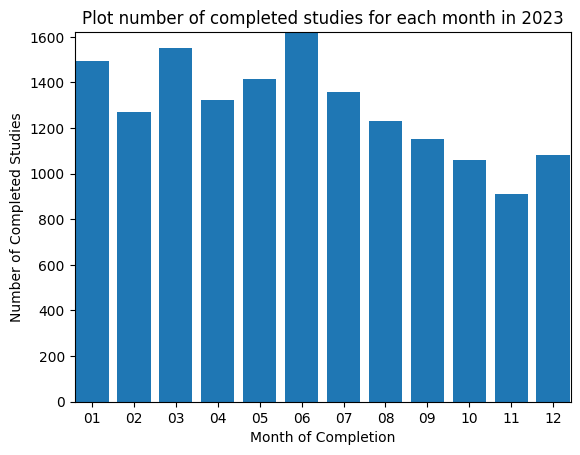

In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('default')

x = num_completed_study_dates_byMonth_RDD.map(lambda line: line[0]).collect()
y = num_completed_study_dates_byMonth_RDD.map(lambda line: line[1]).collect()

plt.bar(x,y)
plt.margins(0.001)

plt.xlabel('Month of Completion')
plt.ylabel('Number of Completed Studies')
plt.title('Plot number of completed studies for each month in 2023')
plt.show()